In [1]:
import numpy as np
import sympy as sp
import networkx as nx
import matplotlib as plt
from collections import Counter
import itertools
import warnings
import tqdm
import time
import datetime
import functools
import matplotlib.pyplot
import numba
# import pydot
# from networkx.drawing.nx_pydot import write_dot

%matplotlib inline

In [212]:
%load_ext snakeviz

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [2]:
def plot_graph(g, pos, labels=None):
    colors = ['r' if val['peg'] else 'b' for val in  g.node.values()]
    nx.draw(g, pos=pos, node_color=colors)
    
def plot_graph_with_labels(g, pos):
    colors = ['r' if val['peg'] else 'b' for val in  g.node.values()]
    labels = {x:x for x in pos.keys()}
    
    edge_colors = [1 if g.edges[edge]['jumped'] else 0 for edge in g.edges ]
    nx.draw(g, pos=pos, node_color=colors, labels=labels, edge_cmap=plt.cm.brg, edge_color=edge_colors)

    
def plot_game(game):    
    occurences = Counter(game.node[g]['holes'] for g in game.nodes())
    
    max_holes = occurences.most_common()[0][0]
    max_board_holes = occurences.most_common()[0][1]

    hole_count = [0]*max_board_holes
    game_pos = {}
    for key in game.node:
        holes = game.node[key]['holes']
        game_pos[key] = (hole_count[holes-1], holes)
        hole_count[holes-1] += 1
    
  
    nx.draw(game, pos=game_pos)
        
    
    

In [35]:
def calc_edges(G):
    for n0, n1 in itertools.combinations(G.node, 2):

        x = G.node[n0]['x']-G.node[n1]['x']
        y = G.node[n0]['y']-G.node[n1]['y']
        if x**2 + y**2 == 1:
            angle = (sp.deg(sp.atan2(y,x))+ 360) % 180
            G.add_edge(n0, n1, angle=angle, jumped=False)

def triangle_solitaire(starting_hole = 4):
    G = nx.Graph()

    x = 0
    y = 0
    ang = sp.rad(60)

    count = 0
    for i in range(5):
        y = -i*sp.sin(ang)
        x = -i*sp.cos(ang)
        for j in range(i+1):
            G.add_node(count, peg=True, x=x, y=y)
            x += 1
            count += 1

    G.node[starting_hole]['peg'] = False    
    
    calc_edges(G)
    
    return G

def cross_solitaire(starting_hole=16):

    def add_holes(G, count, ys, xs):
        for y in ys:
            y = sp.Number(y)
            for x in xs:
                x = sp.Number(x)
                G.add_node(count, peg=True, x=x, y=y)
                count += 1
        return count
         
    G = nx.Graph()
    count = 0 
    count = add_holes(G, count,(0, 1), (2,3,4))
    count = add_holes(G, count, (2,3,4), range(7))
    count = add_holes(G, count, (5, 6), (2,3,4))
    
    G.node[starting_hole]['peg'] = False
    
    calc_edges(G)
    return G

def rhombus_solitaire(starting_hole=20):
    G = nx.Graph()
    x,y = sp.Number(0), sp.Number(0)
    counter = itertools.count()

    ang = sp.rad(60)
    for yi in range(5):
        y = yi*sp.sin(ang)
        for x in range(5):
            x = x + yi*sp.cos(ang)
            G.add_node(next(counter), peg=True, x=x, y=y)
    
    G.node[starting_hole]['peg'] = False
    
    calc_edges(G)   
    return G

G, name = triangle_solitaire(), 'triangle'
# G, name = triangle_solitaire(starting_hole=0), 'triangle_tip'
# G, name = cross_solitaire(), 'cross'
# G, name = rhombus_solitaire(), 'rhombus'

In [36]:
pos = {}
for key in G.node.keys():
    x,y = list(map(lambda z: G.node[key][z].evalf(), 'xy'))
    G.node[key]['x'] = x
    G.node[key]['y'] = y
    pos[key] = (x,y)
    
    
edge_labels = {}
for key, val in G.edges:
    edge_labels[key] = val
    
total_holes = G.number_of_nodes()
max_steps = G.number_of_nodes()-1

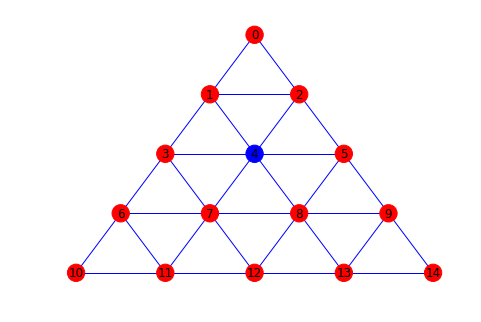

In [37]:
plot_graph_with_labels(G, pos)

In [38]:
def find_neighbor_jumper_pairs(G):
    neighbors = [None]*len(G)
    
    for n0 in G.nodes:
        temp = []
        for n1, v1 in G[n0].items():
            a1 = v1['angle']
            for n2, v2 in G[n1].items():
                a2 = v2['angle']
                if n2 is not n0 and a1==a2:
                    temp.append((n1, n2))
        neighbors[n0] = tuple(temp)
                    
                    
    return tuple(neighbors)             

neighbor_jumper_pairs = find_neighbor_jumper_pairs(G)
neighbor_jumper_pairs  

(((1, 3), (2, 5)),
 ((3, 6), (4, 8)),
 ((4, 7), (5, 9)),
 ((1, 0), (4, 5), (6, 10), (7, 12)),
 ((7, 11), (8, 13)),
 ((2, 0), (4, 3), (8, 12), (9, 14)),
 ((3, 1), (7, 8)),
 ((4, 2), (8, 9)),
 ((4, 1), (7, 6)),
 ((5, 2), (8, 7)),
 ((6, 3), (11, 12)),
 ((7, 4), (12, 13)),
 ((7, 3), (8, 5), (11, 10), (13, 14)),
 ((8, 4), (12, 11)),
 ((9, 5), (13, 12)))

In [45]:
def occupancy_list(g):
    return list(map(lambda key: g.node[key]['peg'], sorted(g.node.keys())))

peg_list = occupancy_list(G)

@numba.njit
def int_repr(pegs):
    x = np.uint64(0)
    for n, peg in enumerate(pegs):
        if peg:
            x += np.power(np.uint64(2), np.uint64(n) )
    return x 

# @numba.njit
def binary_repr(x, width):
    bins = np.binary_repr(x, width=width)[::-1]
    return list(map(bool, map(int, bins)))
    
def binary_to_graph(bins, g):
    for x, y in zip(bins, g.node):
        g.node[y]['peg'] = x
    return g

In [46]:
def jumper(peg_list, neighbor_jumper_pairs):
    for n0, peg in enumerate(peg_list):
        if not peg:
            for n1, n2 in neighbor_jumper_pairs[n0]:
                if peg_list[n1] and peg_list[n2]:
                    for n in (n0, n1, n2):
                        peg_list[n] = not peg_list[n]
                    yield peg_list
                    for n in (n0, n1, n2):
                        peg_list[n] = not peg_list[n]

new_graphs = jumper(peg_list, neighbor_jumper_pairs)

In [47]:
# %%snakeviz
t0 = time.time()


current = {int_repr(occupancy_list(G))}
G_copy = G.copy()

peg_list = occupancy_list(G)

np.save('{}_{}'.format(name, 1), np.array([int_repr(peg_list)]))
for holes in tqdm.tnrange(1, max_steps, desc='holes: '):
    futures = set()
    for current_int in tqdm.tqdm_notebook(current, desc='{:2}/{:2}'.format(holes+1, max_steps)):
        current_pegs = binary_repr(current_int, total_holes) 
        for new_graph in jumper(current_pegs, neighbor_jumper_pairs):
            new_graph = int_repr(new_graph)
            if new_graph not in futures:
                futures.add(new_graph)
    
    np.save('{}_{}'.format(name, holes+1), np.array(list(futures)))
    current = futures

print('Elapsed time: ', datetime.timedelta(seconds=time.time()-t0))

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Elapsed time:  0:00:00.833420


In [48]:
def reverse_jumper(peg_list, neighbor_jumper_pairs):
    for n0, peg in enumerate(peg_list):
        if peg:
            for n1, n2 in neighbor_jumper_pairs[n0]:
                if (not peg_list[n1]) and (not peg_list[n2]):
                    for n in (n0, n1, n2):
                        peg_list[n] = not peg_list[n]
                    yield peg_list
                    for n in (n0, n1, n2):
                        peg_list[n] = not peg_list[n]
            

# Reverse Search Solution

## Finals boards

In [49]:
solution = nx.DiGraph()
boards =  np.load('{}_{}.npy'.format(name, max_steps))

for board_int in boards:
    board_bin = binary_repr(board_int, total_holes)
    board = binary_to_graph(board_bin, G)
    solution.add_node(board_int, board=board)

final_boards = boards
print(boards)

[4096]


## Search backwards

In [50]:
t0 = time.time()
prev_boards = final_boards
circ_pos = {}
for board in final_boards:
    circ_pos[board] = max_steps;
    
for holes in tqdm.tnrange(max_steps-1, 0, -1, desc='holes:'):
# for holes in [max_steps-1]:
    boards = np.load('{}_{}.npy'.format(name, holes))
    temp = set()
    for prev_board in tqdm.tqdm_notebook(prev_boards, desc='{}/{}'.format(holes, max_steps)):
        for next_board in reverse_jumper(binary_repr(prev_board, total_holes), neighbor_jumper_pairs):
            next_int = int_repr(next_board)
            if next_int in boards:
                if next_int not in temp:
                    solution.add_node(next_int, board=binary_to_graph(next_board, G))
                    temp.add(next_int)
                solution.add_edge(next_int, prev_board)
                circ_pos[next_int] = holes
    prev_boards = temp
test = solution.adjacency()
print('Elapsed time: {}'.format(datetime.timedelta(seconds=time.time()-t0)))

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Elapsed time: 0:00:00.613709


In [55]:
next(test)

(24576, {4096: {}})

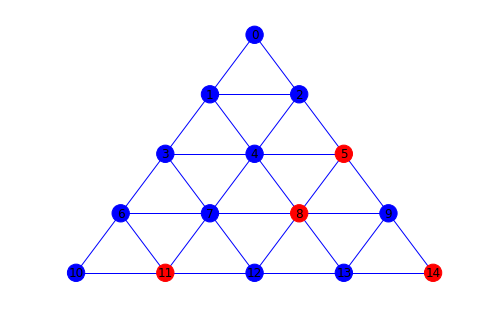

In [62]:
plot_graph_with_labels(binary_to_graph(binary_repr(next(test)[0], total_holes), G), pos)

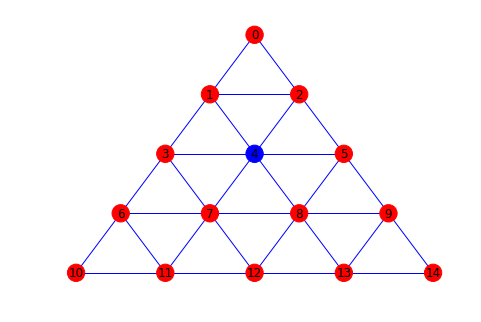

In [57]:
initial_int = np.load('{}_{}.npy'.format(name, holes))[0]
initial_bin = binary_repr(initial_int, total_holes)
initial_graph = binary_to_graph(initial_bin, G)
plot_graph_with_labels(initial_graph, pos)

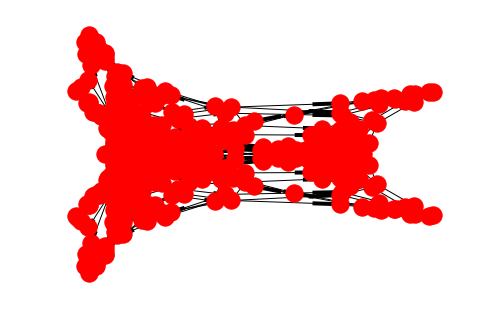

In [34]:
nx.draw_spectral(solution)